# Transformer Models Advanced Training Guide
This guide is showing advanced features of RecTools transformer models training.

### Table of Contents

* Prepare data
* Advanced training guide
    * Validation fold
    * Validation loss
    * Callback for Early Stopping
    * Callbacks for Checkpoints
        * Loading Checkpoints
    * Callbacks for RecSys metrics
        * RecSys metrics for Early Stopping anf Checkpoints
* Advanced training full example
    * Running full training with all of the described validation features on Kion dataset
* More RecTools features for transformers
    * Saving and loading models
    * Configs for transformer models
        * Classes and function in configs
    * Multi-gpu training


In [1]:
import os
import itertools
import typing as tp
import warnings
from collections import Counter
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback

from rectools import Columns, ExternalIds
from rectools.dataset import Dataset
from rectools.metrics import NDCG, Recall, Serendipity, calc_metrics
from rectools.models import BERT4RecModel, SASRecModel, load_model
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.models.nn.transformers.base import TransformerModelBase

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Prepare data

In [2]:
# %%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_en.zip -O data_en.zip
!unzip -o data_en.zip
!rm data_en.zip

In [2]:
# Download dataset
DATA_PATH = Path("./data_en")
items = pd.read_csv(DATA_PATH / 'items_en.csv', index_col=0)
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)

print(interactions.shape)
interactions.head(2)

(5476251, 5)


,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0


In [3]:
interactions[Columns.User].nunique(), interactions[Columns.Item].nunique()

(962179, 15706)

In [4]:
# Process interactions
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
raw_interactions = interactions[["user_id", "item_id", "datetime", "weight"]]
print(raw_interactions.shape)
raw_interactions.head(2)

dataset = Dataset.construct(raw_interactions)

(5476251, 4)


In [5]:
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 60


60

## Advanced Training

### Validation fold

Models do not create validation fold during `fit` by default. However, there is a simple way to force it.

Let's assume that we want to use Leave-One-Out validation for specific set of users. To apply it we need to implement `get_val_mask_func` with required logic and pass it to model during initialization. 

This function should receive interactions with standard RecTools columns and return a binary mask which identifies interactions that should not be used during model training. But instrad should be used for validation loss calculation. They will also be available for Lightning Callbacks to allow RecSys metrics computations.

*Please make sure you do not use `partial` while doing this. Partial functions cannot be by serialized using RecTools.*

In [6]:
# Implement `get_val_mask_func`

N_VAL_USERS = 2048
unique_users = raw_interactions[Columns.User].unique()
VAL_USERS = unique_users[: N_VAL_USERS]

def leave_one_out_mask_for_users(interactions: pd.DataFrame, val_users: ExternalIds) -> np.ndarray:
    rank = (
        interactions
        .sort_values(Columns.Datetime, ascending=False, kind="stable")
        .groupby(Columns.User, sort=False)
        .cumcount()
    )
    val_mask = (
        (interactions[Columns.User].isin(val_users))
        & (rank == 0)
    )
    return val_mask.values

# We do not use `partial` for correct serialization of the model
def get_val_mask_func(interactions: pd.DataFrame):
    return leave_one_out_mask_for_users(interactions, val_users = VAL_USERS)

In this guide we are going to use custom Lighhning trainers. We need to implement function that return desired Lightining trainer and pass it to model during initialization.

In [7]:
# Function to get custom trainer

def get_debug_trainer() -> Trainer:
    return Trainer(
        accelerator="gpu",
        devices=1,
        min_epochs=2,
        max_epochs=2,
        deterministic=True,
        enable_model_summary=False,
        enable_progress_bar=False,
        enable_checkpointing=False,
        limit_train_batches=2,  # limit train batches for quick debug runs
        logger = CSVLogger("test_logs"),  # We use CSV logging for this guide but there are many other options
    )

In [8]:
model = SASRecModel(
    n_factors=64,
    n_blocks=2,
    n_heads=2,
    dropout_rate=0.2,
    train_min_user_interactions=5,
    session_max_len=50,
    verbose=0,
    deterministic=True,
    item_net_block_types=(IdEmbeddingsItemNet,),
    get_val_mask_func=get_val_mask_func,  # pass our custom `get_val_mask_func`
    get_trainer_func=get_debug_trainer,  # pass our custom trainer func
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Validation loss

Let's check how the validation loss is being logged.

In [33]:
# Fit model. Validation fold and validation loss computation will be done under the hood.
model.fit(dataset);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=2` reached.


Let's look at model logs. We can access logs directory with `model.fit_trainer.log_dir`

In [34]:
# What's inside the logs directory?
!ls $model.fit_trainer.log_dir

hparams.yaml  metrics.csv


In [35]:
# Losses and metrics are in the `metrics.csv`
# Let's look at logs

!tail $model.fit_trainer.log_dir/metrics.csv

### Callback for Early Stopping

By default RecTools transfomers train for exact amount of epochs (specified in `epochs` argument).
When `get_trainer_func` is provided, number of model training epochs depends on Lightning trainer arguments instead.

Now that we have validation loss logged, let's use it for model Early Stopping. It will ensure that model will not resume training if validation loss (or any other custom metric) doesn't impove. We have Lightning Callbacks for that.

In [36]:
early_stopping_callback = EarlyStopping(
    monitor=SASRecModel.val_loss_name,   # or just pass "val_loss" here
    mode="min",
    min_delta=1.  # just for a quick test of functionality
)

trainer = Trainer(
    accelerator='gpu',
    devices=1,
    min_epochs=1,  # minimum number of epochs to train before early stopping
    max_epochs=20,  # maximum number of epochs to train
    deterministic=True,
    limit_train_batches=2,  # use only 2 batches for each epoch for a test run
    enable_checkpointing=False,
    logger = CSVLogger("test_logs"),
    callbacks=early_stopping_callback,  # pass our callback
    enable_progress_bar=False,
    enable_model_summary=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


We want to pass our new trainer to model.  
We just want to quickly check functionality for now and we already have model initialized. So let's just assign new trainer to model `_trainer` attribute.

In [38]:
# Replace trainer with our custom one
model._trainer = trainer

# Fit model. Everything will happen under the hood
model.fit(dataset);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Here model stopped training after 4 epochs because validation loss wasn't improving by our specified `min_delta`

In [39]:
# Let's check out logs
!tail $model.fit_trainer.log_dir/metrics.csv

### Callback for Checkpoints
Checkpoints are model states that are saved periodically during training.

In [40]:
# Checkpoint last epoch
last_epoch_ckpt = ModelCheckpoint(filename="last_epoch")

# Checkpoints based on validation loss
least_val_loss_ckpt = ModelCheckpoint(
    monitor=SASRecModel.val_loss_name,   # or just pass "val_loss" here,
    mode="min",
    filename="{epoch}-{val_loss:.2f}",
    save_top_k=2,  # Let's save top 2 checkpoints for validation loss
)

In [41]:
trainer = Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=1,
    max_epochs=6,
    deterministic=True,
    limit_train_batches=2,  # use only 2 batches for each epoch for a test run
    logger = CSVLogger("test_logs"),
    callbacks=[last_epoch_ckpt, least_val_loss_ckpt],  # pass our callbacks for checkpoints
    enable_progress_bar=False,
    enable_model_summary=False,
)

# Replace trainer with our custom one
model._trainer = trainer

# Fit model. Everything will happen under the hood
model.fit(dataset);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=6` reached.


Let's look at model checkpoints that were saved. By default they are neing saved to `checkpoints` directory in  `model.fit_trainer.log_dir`

In [42]:
# We have 2 checkpoints for 2 best validation loss values and one for last epoch
!ls $model.fit_trainer.log_dir/checkpoints

epoch=4-val_loss=21.52.ckpt  epoch=5-val_loss=21.24.ckpt  last_epoch.ckpt


#### Loading checkpoints

Loading checkpoints is very simple with `load_from_weights_from_checkpoint` method.

In [44]:
ckpt_path = os.path.join(model.fit_trainer.log_dir, "checkpoints", "last_epoch.ckpt")
model.load_weights_from_checkpoint(ckpt_path)
model.recommend(users=VAL_USERS[:1], dataset=dataset, filter_viewed=True, k=5)

,user_id,item_id,score,rank
0,176549,15297,0.675964,1
1,176549,2657,0.661444,2
2,176549,10440,0.562942,3
3,176549,4495,0.557208,4
4,176549,6443,0.546108,5


You can also load both model and its weights from checkpoint using `load_from_checkpoint` class method.
Note that there is an  important limitation: **loaded model will not have `fit_trainer` and can't be saved again. But it is fully ready for recommendations.**

In [45]:
ckpt_path = os.path.join(model.fit_trainer.log_dir, "checkpoints", "last_epoch.ckpt")
loaded = SASRecModel.load_from_checkpoint(ckpt_path)
loaded.recommend(users=VAL_USERS[:1], dataset=dataset, filter_viewed=True, k=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


,user_id,item_id,score,rank
0,176549,15297,0.675964,1
1,176549,2657,0.661444,2
2,176549,10440,0.562942,3
3,176549,4495,0.557208,4
4,176549,6443,0.546108,5


### Callbacks for RecSys metrics during training

Monitoring RecSys metrics (or any other custom things) on validation fold is not available out of the box, but we can create a custom Lightning Callback for that.

Below is an example of calculating standard RecTools metrics on validation fold during training. We use it as an explicit example that any customization is possible. But it is recommend to implement metrics calculation using `torch` for faster computations.

Please look at PyTorch Lightning documentation for more details on custom callbacks.

In [9]:
# Implement custom Callback for RecTools metrics computation within validation epochs during training.

class ValidationMetrics(Callback):
    
    def __init__(self, top_k: int, val_metrics: tp.Dict, verbose: int = 0) -> None:
        self.top_k = top_k
        self.val_metrics = val_metrics
        self.verbose = verbose

        self.epoch_n_users: int = 0
        self.batch_metrics: tp.List[tp.Dict[str, float]] = []

    def on_validation_batch_end(
        self, 
        trainer: Trainer, 
        pl_module: LightningModule, 
        outputs: tp.Dict[str, torch.Tensor], 
        batch: tp.Dict[str, torch.Tensor], 
        batch_idx: int, 
        dataloader_idx: int = 0
    ) -> None:
        logits = outputs["logits"]
        if logits is None:
            logits = pl_module.torch_model.encode_sessions(batch["x"], pl_module.item_embs)[:, -1, :]
        _, sorted_batch_recos = logits.topk(k=self.top_k)

        batch_recos = sorted_batch_recos.tolist()
        targets = batch["y"].tolist()

        batch_val_users = list(
            itertools.chain.from_iterable(
                itertools.repeat(idx, len(recos)) for idx, recos in enumerate(batch_recos)
            )
        )

        batch_target_users = list(
            itertools.chain.from_iterable(
                itertools.repeat(idx, len(targets)) for idx, targets in enumerate(targets)
            )
        )

        batch_recos_df = pd.DataFrame(
            {
                Columns.User: batch_val_users,
                Columns.Item: list(itertools.chain.from_iterable(batch_recos)),
            }
        )
        batch_recos_df[Columns.Rank] = batch_recos_df.groupby(Columns.User, sort=False).cumcount() + 1

        interactions = pd.DataFrame(
            {
                Columns.User: batch_target_users,
                Columns.Item: list(itertools.chain.from_iterable(targets)),
            }
        )

        prev_interactions = pl_module.data_preparator.train_dataset.interactions.df
        catalog = prev_interactions[Columns.Item].unique()

        batch_metrics = calc_metrics(
            self.val_metrics, 
            batch_recos_df,
            interactions, 
            prev_interactions,
            catalog
        )

        batch_n_users = batch["x"].shape[0]
        self.batch_metrics.append({metric: value * batch_n_users for metric, value in batch_metrics.items()})
        self.epoch_n_users += batch_n_users

    def on_validation_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        epoch_metrics = dict(sum(map(Counter, self.batch_metrics), Counter()))
        epoch_metrics = {metric: value / self.epoch_n_users for metric, value in epoch_metrics.items()}

        self.log_dict(epoch_metrics, on_step=False, on_epoch=True, prog_bar=self.verbose > 0)

        self.batch_metrics.clear()
        self.epoch_n_users = 0

#### RecSys metrics for Early Stopping and Checkpoints
When custom metrics callback is implemented, we can use the values of these metrics for both Early Stopping and Checkpoints.

In [10]:
# Initialize callbacks for metrics calculation and checkpoint based on NDCG value

metrics = {
    "NDCG@10": NDCG(k=10),
    "Recall@10": Recall(k=10),
    "Serendipity@10": Serendipity(k=10),
}
top_k = max([metric.k for metric in metrics.values()])

# Callback for calculating RecSys metrics
val_metrics_callback = ValidationMetrics(top_k=top_k, val_metrics=metrics, verbose=0)

# Callback for checkpoint based on maximization of NDCG@10
best_ndcg_ckpt = ModelCheckpoint(
    monitor="NDCG@10",
    mode="max",
    filename="{epoch}-{NDCG@10:.2f}",
)

In [11]:
trainer = Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=1,
    max_epochs=6,
    deterministic=True,
    limit_train_batches=2,  # use only 2 batches for each epoch for a test run
    logger = CSVLogger("test_logs"),
    callbacks=[val_metrics_callback, best_ndcg_ckpt],  # pass our callbacks
    enable_progress_bar=False,
    enable_model_summary=False,
)

# Replace trainer with our custom one
model._trainer = trainer

# Fit model. Everything will happen under the hood
model.fit(dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=6` reached.


We have checkpoint for best NDCG@10 model in the usual directory for checkpoints

In [12]:
!ls $model.fit_trainer.log_dir/checkpoints

epoch=5-NDCG@10=0.01.ckpt


We also now have metrics in our logs. Let's load them

In [13]:
def get_logs(model: TransformerModelBase) -> tp.Tuple[pd.DataFrame, ...]:
    log_path = Path(model.fit_trainer.log_dir) / "metrics.csv"
    epoch_metrics_df = pd.read_csv(log_path)
    
    loss_df = epoch_metrics_df[["epoch", "train_loss"]].dropna()
    val_loss_df = epoch_metrics_df[["epoch", "val_loss"]].dropna()
    loss_df = pd.merge(loss_df, val_loss_df, how="inner", on="epoch")
    loss_df.reset_index(drop=True, inplace=True)
    
    metrics_df = epoch_metrics_df.drop(columns=["train_loss", "val_loss"]).dropna()
    metrics_df.reset_index(drop=True, inplace=True)

    return loss_df, metrics_df

loss_df, metrics_df = get_logs(model)

loss_df.head()

,epoch,train_loss,val_loss
0,0,22.383919,22.365339
1,1,22.898216,22.189852
2,2,22.218102,21.964468
3,3,22.875019,21.701391
4,4,21.739164,21.417864


In [14]:
metrics_df.head()

,NDCG@10,Recall@10,Serendipity@10,epoch,step
0,0.000052,0.000657,0.000004,0,1
1,0.002204,0.024984,0.000006,1,3
2,0.006865,0.071006,0.000004,2,5
3,0.009856,0.097304,0.000003,3,7
4,0.010442,0.107824,0.000002,4,9


In [15]:
del model
torch.cuda.empty_cache()

## Advanced training full example
Running full training with all of the described validation features on Kion dataset

In [17]:
# seed again for reproducibility of this piece of code
seed_everything(RANDOM_STATE, workers=True)

# Callbacks
val_metrics_callback = ValidationMetrics(top_k=top_k, val_metrics=metrics, verbose=0)
best_ndcg_ckpt = ModelCheckpoint(
    monitor="NDCG@10",
    mode="max",
    filename="{epoch}-{NDCG@10:.2f}",
)
last_epoch_ckpt = ModelCheckpoint(filename="{epoch}-last_epoch")
early_stopping_callback = EarlyStopping(
    monitor="NDCG@10",
    patience=5,
    mode="max",
)

# Function to get custom trainer with desired callbacks
def get_custom_trainer() -> Trainer:
    return Trainer(
        accelerator="gpu",
        devices=[1],
        min_epochs=1,
        max_epochs=100,
        deterministic=True,
        logger = CSVLogger("sasrec_logs"),
        enable_progress_bar=False,
        enable_model_summary=False,
        callbacks=[
            val_metrics_callback,  # calculate RecSys metrics
            best_ndcg_ckpt,  # save best NDCG model checkpoint
            last_epoch_ckpt,  # save model checkpoint after last epoch
            early_stopping_callback,  # early stopping on NDCG
        ],
    )

# Model
model = SASRecModel(
    n_factors=256,
    n_blocks=2,
    n_heads=4,
    dropout_rate=0.2,
    train_min_user_interactions=5,
    session_max_len=50,
    verbose=1,
    deterministic=True,
    item_net_block_types=(IdEmbeddingsItemNet,),
    get_val_mask_func=get_val_mask_func,  # pass our custom `get_val_mask_func`
    get_trainer_func=get_custom_trainer,  # pass function to initialize our custom trainer
)


# Fit model. Everything will happen under the hood
model.fit(dataset);

Seed set to 60
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Early stopping was triggered. We have checkpoints for best NDCG model (on epoch 14) and on last epoch (19)

In [28]:
!ls $model.fit_trainer.log_dir/checkpoints

epoch=14-NDCG@10=0.03.ckpt  epoch=19-last_epoch.ckpt


Loading best NDCG model from checkpoint and recommending

In [29]:
ckpt_path = os.path.join(model.fit_trainer.log_dir, "checkpoints", "epoch=14-NDCG@10=0.03.ckpt")
best_model = SASRecModel.load_from_checkpoint(ckpt_path)
best_model.recommend(users=VAL_USERS[:1], dataset=dataset, filter_viewed=True, k=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

,user_id,item_id,score,rank
0,176549,11749,2.610277,1
1,176549,2025,2.577398,2
2,176549,9342,2.394489,3
3,176549,14488,2.366664,4
4,176549,7571,2.289778,5


Let's also look at our logs for losses and metrics

In [30]:
loss_df, metrics_df = get_logs(model)
pd.concat([metrics_df.head(5), metrics_df.tail(5)])

,NDCG@10,Recall@10,Serendipity@10,epoch,step
0,0.023663,0.183432,0.000067,0,2362
1,0.027919,0.209730,0.000122,1,4725
2,0.029360,0.216305,0.000166,2,7088
3,0.030170,0.226824,0.000203,3,9451
4,0.030412,0.225510,0.000161,4,11814
15,0.031640,0.226167,0.000186,15,37807
16,0.031333,0.230769,0.000203,16,40170
17,0.031238,0.228139,0.000184,17,42533
18,0.031893,0.232084,0.000195,18,44896
19,0.031560,0.230112,0.000179,19,47259


Don't be surprised by the fact that validation loss is less then train loss in the plot below. 
- First, this is data-specific, you may not see this in other datasets. 
- Second, validation loss is calculated after the full training epoch while train loss is computed for each batch during training when model still hasn't seen other batches and hasn't updated weights.
- Validation loss is calculated only in the last item in validation users history. While train loss for SASRec is calculated for each item in user histor except the first one and the validation one.

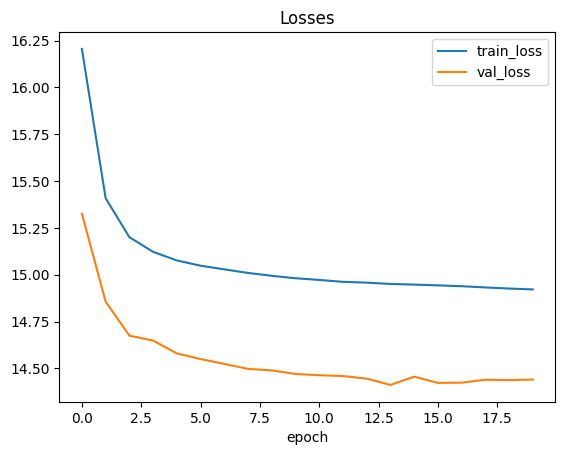

In [31]:
loss_df.plot(kind="line", x="epoch", title="Losses");

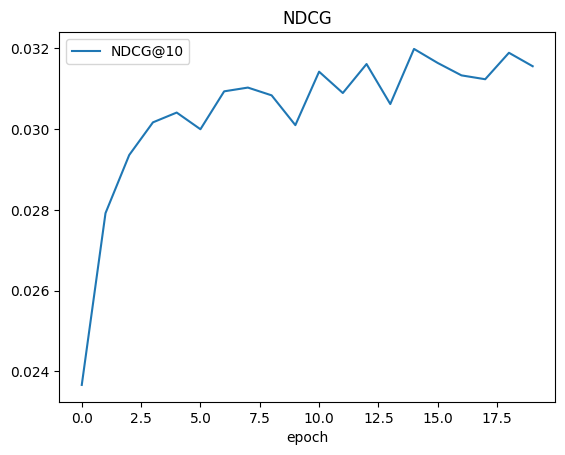

In [32]:
metrics_df[["epoch", "NDCG@10"]].plot(kind="line", x="epoch", title="NDCG");

## More RecTools features for transformers
### Saving and loading models
Transformer models can be saved and loaded just like any other RecTools models. 

*Note that you can't use these common functions for savings and loading lightning checkpoints. Use `load_from_checkpoint` method instead.*

**Note that you shouldn't change code for custom functions and classes that were passed to model during initialization if you want to have correct model saving and loading.** 

In [33]:
model.save("my_model.pkl")

54579980

In [34]:
loaded = load_model("my_model.pkl")
print(type(loaded))
loaded.recommend(users=VAL_USERS[:1], dataset=dataset, filter_viewed=True, k=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


<class 'rectools.models.nn.sasrec.SASRecModel'>


Predicting: |          | 0/? [00:00<?, ?it/s]

,user_id,item_id,score,rank
0,176549,2599,2.681841,1
1,176549,12225,2.516873,2
2,176549,2025,2.416028,3
3,176549,11749,2.410308,4
4,176549,14120,2.356824,5


### Configs for transformer models

`from_config`, `from_params`, `get_config` and `get_params` methods are fully available for transformers just like for any other models.

In [2]:
config = {
    "epochs": 2,
    "n_blocks": 1,
    "n_heads": 1,
    "n_factors": 64, 
}

model = SASRecModel.from_config(config)
model.get_params(simple_types=True)

{'cls': 'SASRecModel',
 'verbose': 0,
 'data_preparator_type': 'rectools.models.nn.transformers.sasrec.SASRecDataPreparator',
 'n_blocks': 1,
 'n_heads': 1,
 'n_factors': 64,
 'use_pos_emb': True,
 'use_causal_attn': True,
 'use_key_padding_mask': False,
 'dropout_rate': 0.2,
 'session_max_len': 100,
 'dataloader_num_workers': 0,
 'batch_size': 128,
 'loss': 'softmax',
 'n_negatives': 1,
 'gbce_t': 0.2,
 'lr': 0.001,
 'epochs': 2,
 'deterministic': False,
 'recommend_batch_size': 256,
 'recommend_device': None,
 'train_min_user_interactions': 2,
 'item_net_block_types': ['rectools.models.nn.item_net.IdEmbeddingsItemNet',
  'rectools.models.nn.item_net.CatFeaturesItemNet'],
 'item_net_constructor_type': 'rectools.models.nn.item_net.SumOfEmbeddingsConstructor',
 'pos_encoding_type': 'rectools.models.nn.transformers.net_blocks.LearnableInversePositionalEncoding',
 'transformer_layers_type': 'rectools.models.nn.transformers.sasrec.SASRecTransformerLayers',
 'lightning_module_type': 'rectoo

#### Classes and functions in configs

Transformer models in RecTools may accept functions and classes as arguments. These types of arguments are fully compatible with RecTools configs. You can eigther pass them as python objects or as strings that define their import paths.

**Note that you shouldn't change code for those functions and classes if you want to have reproducible config and correct model saving and loading.** 

Below is an example of both approaches to pass them to configs:

In [3]:
config = {
    "get_val_mask_func": get_val_mask_func,  # function to get validation mask
    "get_trainer_func": get_custom_trainer, # function to get custom trainer
    # path to transformer layers class:
    "transformer_layers_type": "rectools.models.nn.transformers.sasrec.SASRecTransformerLayers",
}

model = SASRecModel.from_config(config)
model.get_params(simple_types=True)

{'cls': 'SASRecModel',
 'verbose': 0,
 'data_preparator_type': 'rectools.models.nn.transformers.sasrec.SASRecDataPreparator',
 'n_blocks': 2,
 'n_heads': 4,
 'n_factors': 256,
 'use_pos_emb': True,
 'use_causal_attn': True,
 'use_key_padding_mask': False,
 'dropout_rate': 0.2,
 'session_max_len': 100,
 'dataloader_num_workers': 0,
 'batch_size': 128,
 'loss': 'softmax',
 'n_negatives': 1,
 'gbce_t': 0.2,
 'lr': 0.001,
 'epochs': 3,
 'deterministic': False,
 'recommend_batch_size': 256,
 'recommend_device': None,
 'train_min_user_interactions': 2,
 'item_net_block_types': ['rectools.models.nn.item_net.IdEmbeddingsItemNet',
  'rectools.models.nn.item_net.CatFeaturesItemNet'],
 'item_net_constructor_type': 'rectools.models.nn.item_net.SumOfEmbeddingsConstructor',
 'pos_encoding_type': 'rectools.models.nn.transformers.net_blocks.LearnableInversePositionalEncoding',
 'transformer_layers_type': 'rectools.models.nn.transformers.sasrec.SASRecTransformerLayers',
 'lightning_module_type': 'recto

Note that if you didn't pass custom `get_trainer_func`, you can still replace default `trainer` after model initialization. But this way custom trainer will not be saved with the model and will not appear in model config and params.

In [37]:
model._trainer = trainer

### Multi-gpu training
RecTools models use PyTorch Lightning to handle multi-gpu training.
Please refer to Lightning documentation for details. We do not cover it in this guide.